# Deep Learning HW01
Gerald Baulig 0780827 2019/11/05
GitHub: https://github.com/bugerry87/fcnn_scratch

---

In this assignment we are asked to implement a neural network from scratch,
including Backpropagation and Storastic Gradient Decent algorithms.
The assigment includes two tasks:

1. Implement a regression network, and
2. implement a classification network.

# A Neural Network from Scratch

First, let's define what a Neural Network is.
A Neural Network is a class that can train and validate the weight of a stack of layers, w.r.t several hyper-parameters.
However, all what the Neural Network needs to know about his own network is, where to get its output from. Furthermore, the hyper-parameters are only required in the training process, but only few of them in the validation process,
such that the class defination could look like that:

In [492]:
class NeuralNetwork:
    def __init__(self, train_set, val_set, cost_func, loss_func):
        self.train_set = train_set
        self.val_set = val_set
        self.cost = cost_func
        self.loss = loss_func
        pass
    
    def train(self, output_layer, lr, lr_dec):
        self.lr = lr
        self.lr_dec = lr_dec
        self.training = True
        for Y in output_layer.poll_forward():
            Z = np.squeeze(self.cost.f(self.T, Y))
            dZ = self.cost.d(self.T, Y)
            output_layer.push_backward(dZ, self.lr)
            self.lr -= self.lr * self.lr_dec
            yield Z 
        pass
    
    def val(self, output_layer):
        self.training = False
        for Y in output_layer.poll_forward():
            Z = self.loss.f(self.T, Y)
            yield Z
        pass        
    
    def gen_input(self):
        if self.training:
            for self.X, self.T, self.epoch, self.step in self.train_set():
                yield self.X
        else:
            for self.X, self.T, _, _ in self.val_set():
                yield self.X
        pass

## Let's Define a Fully-Connected Layer

In [493]:
class Layer:
    pass

class FcLayer(Layer):
    def __init__(self,
                 params,
                 act_func,
                 input_func,
                 backprop,
                 clipping=False
                ):
        self.w = params[0]
        self.b = params[1]
        self.act = act_func
        self.input = input_func
        self.backprop = backprop
        self.clipping = clipping
        pass
    
    def poll_forward(self):
        '''Polls the output from the underlying layer. (Feed Forward)'''
        for self.x in self.input():
            self.y = self.act.f(np.dot(self.x, self.w) + self.b)
            yield self.y
    
    def push_backward(self, dZ, lr):
        '''Pushes the loss to the underlying layer. (Back Propagation)'''
        dZ *= self.act.d(self.y)
        dw = np.dot(self.x.T, dZ)
        if self.backprop:
            self.backprop(np.dot(dZ, self.w.T), lr)
        self.w += dw * lr if not self.clipping else np.clip(dw * lr, -self.clipping, self.clipping)
        if not self.b is 0:
            self.b += np.sum(dZ, axis=0) * lr
        pass

## Some Activation Functions

### ReLU

In [494]:
import numpy as np
class ReLU:
    def f(x):
        return np.maximum(x,0).astype(float)
    
    def d(y):
        return (y > 0).astype(float)

#test
print(ReLU.f(np.array([1,-1,5,-5,0])))
print(ReLU.d(np.array([1,-1,5,-5,0])))

[1. 0. 5. 0. 0.]
[1. 0. 1. 0. 0.]


### Sigmoid

In [495]:
import numpy as np
class Sigmoid:
    def f(x):
        return 1 / (1 + np.exp(x))
    
    def d(S):
        #S = Sigmoid.f(S)
        return S * (1 - S)

#test
print(Sigmoid.f(np.array([1,-1,5,-5,0])))
print(Sigmoid.d(np.array([1,-1,5,-5,0])))

[0.26894142 0.73105858 0.00669285 0.99330715 0.5       ]
[  0  -2 -20 -30   0]


### Linear

In [496]:
import numpy as np
class Linear:
    def f(x):
        return x
    
    def d(y):
        return np.ones(y.shape)

#test
print(Linear.f(np.array([1,-1,5,-5,0])))
print(Linear.d(np.array([1,-1,5,-5,0])))

[ 1 -1  5 -5  0]
[1. 1. 1. 1. 1.]


# 1. Implement a Regression Network

Implement a regression network for the engery efficiency dataset.
I guess this dataset descripes the termal exchange of a building to its environment.
The dataset has 2 Values (t):

- Heating load, and
- Cooling load

And 8 features:

- Relative compactness,
- Surface area,
- Wall area,
- Roof area,
- Overall hight,
- Orientation,
- Glazing area, and
- Glazing area distribution.

We are required to define a feature-vector out of these features and predict the heating load of the buildings, by minimizing the "sum-of-squares" error function,

$$
\begin{equation}
E(w) = \sum_{n=1}^{N}{(t_n - y(X_n;w))^2}
\tag{1}
\end{equation}
$$

...while the evaluation should be processed by the "root-mean-square" error (basically an Euclidean distance :-),

$$
\begin{equation}
E_{RMS}(w) = \frac{\sqrt{\sum_{n=1}^{N}{(t_n - y(x_n;w))^2}}}{\sqrt{N}}
\tag{2}
\end{equation}
$$

## Loss & Cost Functions

In [497]:
import numpy as np
class SOS:
    def f(t, y):
        return np.sum(np.power(t - y, 2))
    
    def d(t, y):
        return (t - y) * 2
    
class RMS:
    def f(t, y):
        return np.power(SOS.f(t, y) / t.size, 0.5)
    
    def d(t, y):
        return (SOS.d(t, y) / t.size) * 0.5

#test
print("SOS.f", SOS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("SOS.d", SOS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.f", RMS.f(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))
print("RMS.d", RMS.d(np.array([1,-2,5,-5,0]), np.array([1,-1,5,-10,0])))

SOS.f 26
SOS.d [ 0 -2  0 10  0]
RMS.f 2.280350850198276
RMS.d [ 0.  -0.2  0.   1.   0. ]


## Load and prepare Energy Efficiency Data

In [498]:
import numpy as np

def unpack_EE_data():
    raw = np.genfromtxt('EnergyEfficiency_data.csv', skip_header=1, delimiter=',')
    N = raw.shape[0]
    data = np.zeros((N,17))
    data[:,:3] = raw[:,:3]     #comp, surf, wall
    data[:,3] = raw[:,3]       #roof
    data[:,4] = raw[:,4]       #hight
    data[:,5] = raw[:,5] == 2  #ori north
    data[:,6] = raw[:,5] == 3  #ori east
    data[:,7] = raw[:,5] == 4  #ori south
    data[:,8] = raw[:,5] == 5  #ori west
    data[:,9] = raw[:,6]       #area
    data[:,10] = raw[:,7] == 1 #area uniform
    data[:,11] = raw[:,7] == 2 #area north
    data[:,12] = raw[:,7] == 3 #area east
    data[:,13] = raw[:,7] == 4 #area south
    data[:,14] = raw[:,7] == 5 #area west
    data[:,15:] = raw[:,8:]    #heat, cold
    return data, N

def gen_EE_data(data, epochs, batch_size=None, with_trails=False):
    batch_size = batch_size if batch_size else data.shape[0]
    step = 0
    N = data.shape[0]
    X = np.zeros((batch_size, 15))
    T = np.zeros((batch_size, 2))
    for e in range(epochs):
        for n in range(N):
            i = int(step % batch_size)
            X[i] = data[n,:15]
            T[i] = data[n,-2:]
            step += 1
            is_trail = not with_trails and n+batch_size >= N
            if not step % batch_size:
                yield X, T, e+is_trail, step
        if with_trails and step % batch_size:
            yield X[:i], T[:i], e+1, step

def split_data(data, N, split):
    shuffle = np.arange(N)
    np.random.shuffle(shuffle)
    split = int(N*split)
    train_idx = shuffle[:split]
    val_idx = shuffle[split:]
    train = data[train_idx]
    val = data[val_idx]
    return train, val, train_idx, val_idx

def normalize_data(data, mean=None, var=None):
    mean = mean if not mean is None else np.mean(data, axis=0)
    var = var if not var is None else np.var(data, axis=0)
    data = (data - mean) / (var + (var==0))
    return data, mean, var

data, N = unpack_EE_data()
train, val, train_idx, val_idx = split_data(data, N, 0.75)
train, mean, var = normalize_data(train, mean=0)
val, _, _ = normalize_data(val, mean, var)
data, _, _ = normalize_data(data, mean, var)

#test
print(data[:3])
print("Data Shape:", data.shape)

[[8.77741037e+01 6.67474771e-02 1.55704026e-01 5.42651875e-02
  2.28582452e+00 5.19211268e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51767649e-01
  2.37591078e-01]
 [8.77741037e+01 6.67474771e-02 1.55704026e-01 5.42651875e-02
  2.28582452e+00 0.00000000e+00 5.33333333e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51767649e-01
  2.37591078e-01]
 [8.77741037e+01 6.67474771e-02 1.55704026e-01 5.42651875e-02
  2.28582452e+00 0.00000000e+00 0.00000000e+00 5.46196270e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 0.00000000e+00
  0.00000000e+00 0.00000000e+00 0.00000000e+00 1.51767649e-01
  2.37591078e-01]]
Data Shape: (768, 17)


## Configure the Regression Network

Now let's configure our network.
Thanks to Pythons prototyping feature, we simply add each layer to our NeuralNetwork instance.
For a more photonic initalization of the parameters we define a function `init_params`.
With this function we define how many inputs our layer expects and how many outputs this layer will produce.
The number of inputs must be equivalent to the number of nodes the previous layer has,
while output it the number of nodes the current layer has.

Furthermore, there are a lot of hyper-parameters in the parameter initialization.
Few of them are weight-scaling, the use of bias and the initalization itself.
In default we choose an unscaled natural distributed random generator with bias.

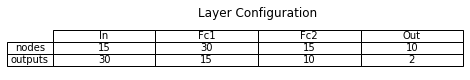

In [499]:
import matplotlib.pyplot as plt
import numpy as np

def init_params(inp, outp, scale=1, bias=True, init_func=np.random.randn):
    weights = init_func(inp, outp)
    while not np.all(weights):
        malicious = weights==0.0
        weights[malicious] = init_func(malicious.shape)
    weights *= scale
    return weights, np.zeros(outp) if bias else 0

def init_EE_network(epochs, batch_size):
    nn = NeuralNetwork(
        lambda: gen_EE_data(train, epochs, batch_size),
        lambda: gen_EE_data(val, 1, 1),
        SOS,
        RMS
    )

    nn.In = FcLayer(init_params(15, 30, scale=0.5),
                  Sigmoid,
                  nn.gen_input,
                  None,
                  #clipping=1
                 )

    nn.Fc1 = FcLayer(init_params(30, 15, scale=0.5),
                  ReLU,
                  nn.In.poll_forward,
                  nn.In.push_backward,
                  clipping=1
                 )

    nn.Fc2 = FcLayer(init_params(15, 10, scale=0.5),
                  ReLU,
                  nn.Fc1.poll_forward,
                  nn.Fc1.push_backward,
                  clipping=1
                 )

    nn.Out = FcLayer(init_params(10, 2, scale=0.5),
                  Linear,
                  nn.Fc2.poll_forward,
                  nn.Fc2.push_backward
                 )
    
    # let's map the model to a dictionery for easy access
    nn.model = {
        'In':(nn.In.w, nn.In.b),
        'Fc1':(nn.Fc1.w, nn.Fc1.b),
        'Fc2':(nn.Fc2.w, nn.Fc2.b),
        'Out':(nn.Out.w, nn.Out.b)
    }
    return nn

#test
def plot_net_conf(nn):
    row_labels = []
    nodes = []
    outputs = []
    for k,v in nn.model.items():
        row_labels.append(k)
        nodes.append(v[0].shape[0])
        outputs.append(v[0].shape[1])

    plt.figure(figsize=(6,1))
    plt.axis('off')
    plt.axis('tight')
    plt.tight_layout()
    plt.table(cellText=[nodes, outputs],
              rowLabels=['nodes', 'outputs'],
              colLabels=row_labels,
              cellLoc='center',
              rowLoc='center',
              loc='center'
             )
    plt.title("Layer Configuration")
    plt.show()
    pass

plot_net_conf(init_EE_network(1, 1))

## Save and Load

Copy, save and load are important functionalities during the training process.
Each epoch we will test our model against a validation set.
While our model approaches more and more the training set,
the model will reach a point where it start to overfit
and the loss of the validation will rise up again.
Before this happen we want to caputre the best model,
by storing the best result after each epoch.
Fortunatelly, copying, storing and loading are easy to implement with Pickle.

In [500]:
import pickle

def dump(nn, model):
    '''Dumps the params of a given NeuralNetwork into a dictionary.
    The dictionary must have the attribute name of the layer as a key.
    E.g.: nn.layer1 --> model['layer1']
    
    Agrs:
        nn: The NeuralNetwork
        model: A dict where the params get stored at
    '''
    for k,v in model.items():
        layer = getattr(nn, k)
        model[k] = (layer.w.copy(), 0 if layer.b is 0 else layer.b.copy())
    pass

def assign(model, nn):
    '''Assigns the params of a given dictionary into a NeuralNetwork.
    The dictionary must have the attribute name of the layer as a key.
    E.g.: model['layer1'] --> nn.layer1
    
    Agrs:
        model: A dict with parameters
        nn: The NeuralNetwork where the params get stored at
    '''
    for k,v in model.items():
        layer = getattr(nn, k)
        layer.w = model[k][0].copy()
        layer.b = model[k][1].copy()
    pass

def save(model, name):
    with open(name, 'wb') as file:
        pickle.dump(model, file)
    pass

def load(nn, name):
    with open(name, 'rb') as file:
        obj = pickle.load(file)
    for k,v in obj.items():
        if hasattr(nn, k):
            layer = getattr(nn, k)
            layer.w = v[0]
            layer.b = v[1]
    pass

#test
dump(nn, nn.model)
assign(nn.model, nn)
save(nn.model, "test.pkl")
load(nn, "test.pkl")

## Train the Regression Network

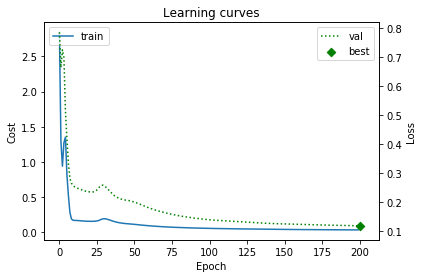

Best Epoch: 200 with a Loss of: 0.11888132871418922


In [515]:
import numpy as np
#Setup some hyper-parameters
np.random.seed(1) #how about your lucky number?
epochs = 200
batch_size = None #None for complete dataset
lr = 1e-5
lr_dec = 1e-10

#reload data
data, N = unpack_EE_data()
train, val, train_idx, val_idx = split_data(data, N, 0.75)
train, mean, var = normalize_data(train, mean=0)
val, _, _ = normalize_data(val, mean, var)
data, _, _ = normalize_data(data, mean, var)

#reset the model
nn = init_EE_network(epochs, batch_size)

def run_training(nn, lr, lr_dec):
    training = []
    validation = []
    epoch = 0
    cost = 0
    best_loss = None
    best_epoch = 0
    
    for Z in nn.train(nn.Out, lr, lr_dec):
        cost += Z / train.shape[0]
        if nn.epoch > epoch:
            loss = 0
            epoch = nn.epoch
            
            for Zv in nn.val(nn.Out):
                loss += Zv / val.shape[0]
                
            if best_loss is None or loss < best_loss:
                best_loss = loss
                best_epoch = epoch
                dump(nn, nn.model)
                
            validation.append(loss)
            training.append(cost)
            cost = 0
    return training, validation, best_epoch, best_loss

def train_n_plot(nn, lr, lr_dec, checkpoint=None):
    training, validation, best_epoch, best_loss = run_training(nn, lr, lr_dec)
    if checkpoint:
        save(nn.model, checkpoint)
    ax_l = plt.figure().subplots(1)
    ax_l.plot(range(nn.epoch), training, label='train')
    ax_l.set_xlabel("Epoch")
    ax_l.set_ylabel("Cost")
    
    ax_r = ax_l.twinx()
    ax_r.plot(range(nn.epoch), validation, 'g:', label='val')
    ax_r.scatter(best_epoch, best_loss, color='g', marker='D', zorder=3, label='best')
    ax_r.set_ylabel("Loss")
    
    ax_l.legend(loc=2)
    ax_r.legend()
    
    plt.title("Learning curves")
    plt.show()
    print("Best Epoch:", best_epoch, "with a Loss of:", best_loss)
    pass

#test
train_n_plot(nn, lr, lr_dec, "checkpointEE.pkl")

## Qualitative Evaluation

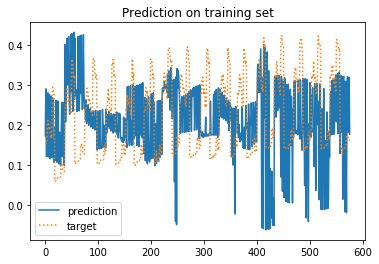

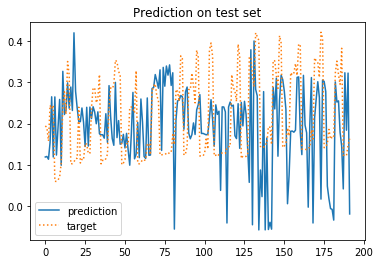

In [486]:
def plot_prediction(nn):
    load(nn, "checkpointEE.pkl")

    nn.val_set = lambda: gen_EE_data(train[np.argsort(train_idx)], 1, 1)
    nn.loss = RMS
    target = []
    pred = []
    for Zv in nn.val(nn.Out):
        target.append(nn.T[0][0])
        pred.append(nn.Out.y[0][0])

    plt.plot(range(len(pred)), pred, label='prediction')
    plt.plot(range(len(target)), target, label='target', linestyle=':')
    plt.title("Prediction on training set")
    plt.legend()
    plt.show()

    nn.val_set = lambda: gen_EE_data(val[np.argsort(val_idx)], 1, 1)
    target = []
    pred = []
    for Zv in nn.val(nn.Out):
        target.append(nn.T[0][0])
        pred.append(nn.Out.y[0][0])

    plt.plot(range(len(pred)), pred, label='prediction')
    plt.plot(range(len(target)), target, label='target', linestyle=':')
    plt.title("Prediction on test set")
    plt.legend()
    plt.show()
    pass

plot_prediction(nn)

## Impact of Input Features

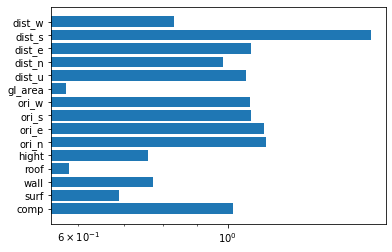

In [399]:
def plot_input_weights():
    input_var = np.var(nn.In.w, axis=1)
    y_pos = np.arange(input_var.size)
    labels = ('comp', 'surf', 'wall', 'roof', 'hight',
              'ori_n', 'ori_e', 'ori_s', 'ori_w',
              'gl_area',
              'dist_u', 'dist_n', 'dist_e', 'dist_s', 'dist_w'
             )
    plt.barh(y_pos, invar)
    plt.xscale('log')
    plt.yticks(y_pos, labels)
    plt.show()
    pass

plot_input_weights()

# 2. Implement a Classifier

Implement a classification network for the Ionosphere dataset.



In [525]:
import numpy as np
from scipy.special import xlogy, xlog1py

class CE:
    def f(t,y):
        #return -np.sum(np.sum(np.dot(t, np.log(y.T)), axis=1)) / t.shape[1] #multy class
        #return -np.sum(np.dot(t, np.log(y.T)) + np.dot(1 - t, np.log(1 - y.T))) / t.shape[1]
        return -np.sum(xlogy(t, y) + xlog1py(1 - t, -y)) / t.shape[1]
    
    def d(t,y):
        return (y - t) / t.shape[1]

class AMax:
    def f(t,y):
        return np.sum(np.argmax(t, axis=1) != np.argmax(y, axis=1)) / t.shape[0]
    
    def d(t,y):
        z = np.zeros(y.shape)
        z[0,np.argmax(y, axis=1)[0]] = 1
        return (z - t) / t.shape[1]

#test
print("CE.f", CE.f(np.array([[1,0]]), np.array([[1,0]])))
print("CE.d", CE.d(np.array([[1,0]]), np.array([[1,0]])))
print("AMax.f", AMax.f(np.array([[1,0]]), np.array([[1,0]])))
print("AMax.d", AMax.d(np.array([[0,1,0]]), np.array([[0,0,1]])))

CE.f -0.0
CE.d [[0. 0.]]
AMax.f 0.0
AMax.d [[ 0.         -0.33333333  0.33333333]]


## Load and prepare Ionosphere Data

In [460]:
import numpy as np
import pandas as pd

def unpack_Ion_data():
    raw = pd.read_csv("ionosphere_csv.csv")
    raw = raw.values
    N = raw.shape[0]
    data = np.zeros((N, raw.shape[1]+1))
    data[:,:-2] = raw[:,:-1]
    data[:,-2] = raw[:,-1] == 'g'
    data[:,-1] = raw[:,-1] == 'b'
    return data, N

def gen_Ion_data(data, epochs, batch_size=None, with_trails=False):
    batch_size = batch_size if batch_size else data.shape[0]
    step = 0
    N = data.shape[0]
    K = 2
    F = data.shape[1] - K
    X = np.zeros((batch_size, F))
    T = np.zeros((batch_size, K))
    for e in range(epochs):
        for n in range(N):
            i = int(step % batch_size)
            X[i] = data[n,:F]
            T[i] = data[n,-K]
            step += 1
            is_trail = not with_trails and n+batch_size >= N
            if not step % batch_size:
                yield X, T, e+is_trail, step
        if with_trails and step % batch_size:
            yield X[:i], T[:i], e+1, step

data, N = unpack_Ion_data()

#test
print(data[:3])
print("Data Shape:", data.shape)

[[ 1.       0.       0.99539 -0.05889  0.85243  0.02306  0.83398 -0.37708
   1.       0.0376   0.85243 -0.17755  0.59755 -0.44945  0.60536 -0.38223
   0.84356 -0.38542  0.58212 -0.32192  0.56971 -0.29674  0.36946 -0.47357
   0.56811 -0.51171  0.41078 -0.46168  0.21266 -0.3409   0.42267 -0.54487
   0.18641 -0.453    1.       0.     ]
 [ 1.       0.       1.      -0.18829  0.93035 -0.36156 -0.10868 -0.93597
   1.      -0.04549  0.50874 -0.67743  0.34432 -0.69707 -0.51685 -0.97515
   0.05499 -0.62237  0.33109 -1.      -0.13151 -0.453   -0.18056 -0.35734
  -0.20332 -0.26569 -0.20468 -0.18401 -0.1904  -0.11593 -0.16626 -0.06288
  -0.13738 -0.02447  0.       1.     ]
 [ 1.       0.       1.      -0.03365  1.       0.00485  1.      -0.12062
   0.88965  0.01198  0.73082  0.05346  0.85443  0.00827  0.54591  0.00299
   0.83775 -0.13644  0.75535 -0.0854   0.70887 -0.27502  0.43385 -0.12062
   0.57528 -0.4022   0.58984 -0.22145  0.431   -0.17365  0.60436 -0.2418
   0.56045 -0.38238  1.       0.   

## Configure Classification Network

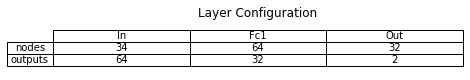

In [519]:
import matplotlib.pyplot as plt
import numpy as np

def init_Ion_network(epochs, batch_size):
    nn = NeuralNetwork(
        lambda: gen_Ion_data(train, epochs, batch_size),
        lambda: gen_Ion_data(val, 1, 1),
        CE,
        AMax
    )

    nn.In = FcLayer(init_params(34, 64, scale=1),
                  Sigmoid,
                  nn.gen_input,
                  None,
                  #clipping=1
                 )

    nn.Fc1 = FcLayer(init_params(64, 32, scale=1),
                  Sigmoid,
                  nn.In.poll_forward,
                  nn.In.push_backward,
                  #clipping=1
                 )

    nn.Out = FcLayer(init_params(32, 2, scale=1),
                  Sigmoid,
                  nn.Fc1.poll_forward,
                  nn.Fc1.push_backward,
                  #clipping=1
                 )
    
    # let's map the model to a dictionery for easy access
    nn.model = {
        'In':(nn.In.w, nn.In.b),
        'Fc1':(nn.Fc1.w, nn.Fc1.b),
        'Out':(nn.Out.w, nn.Out.b)
    }
    return nn

plot_net_conf(init_Ion_network(1, 1))

## Train the Classification Network

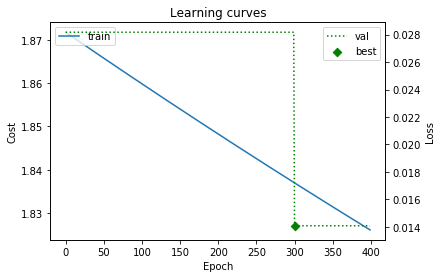

Best Epoch: 301 with a Loss of: 0.014084507042253521


In [535]:
import numpy as np
#Setup some hyper-parameters
np.random.seed(2) #how about your lucky number?
epochs = 400
batch_size = None #None for complete dataset
lr = 1e-5
lr_dec = 1e-10

#reload data
data, N = unpack_Ion_data()
train, val, train_idx, val_idx = split_data(data, N, 0.8)

#reset model
nn2 = init_Ion_network(epochs, batch_size)

#run training
train_n_plot(nn2, lr, lr_dec, "checkpointIon.pkl")

In [536]:
def print_prediction(nn):
    load(nn, "checkpointIon.pkl")

    nn.val_set = lambda: gen_Ion_data(train[np.argsort(train_idx)], 1,  None)
    nn.loss = AMax
    for Zv in nn.val(nn.Out):
        print("Accuracy on training set:\t", (1-Zv)*100, "%")

    nn.val_set = lambda: gen_Ion_data(val[np.argsort(val_idx)], 1, None)
    pred = []
    for Zv in nn.val(nn.Out):
        print("Accuracy on validation set:\t", (1-Zv)*100, "%")
    pass

print_prediction(nn2)

Accuracy on training set:	 96.42857142857143 %
Accuracy on validation set:	 98.59154929577466 %


## Visualize Learnd Dimensions

In [ ]:
def viz_dims():
    pass